# Exercise 2

In [1]:
# Importing libs
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
%matplotlib notebook

## 1.1 Write a program which increases the brightness of an image and paint black vertical strips on it.  

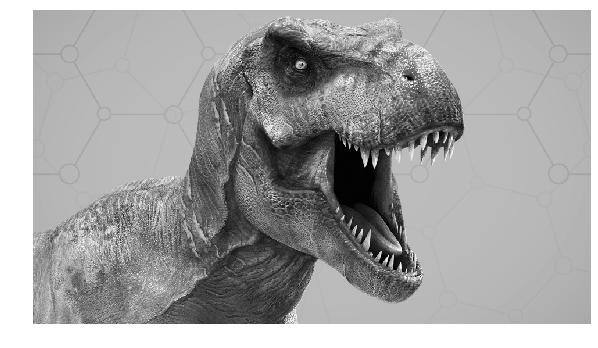

In [2]:
t_rex = cv2.imread('images/t_rex.jpg', 0)

plt.figure(figsize=(10, 10))
plt.imshow(t_rex, cmap='gray')
plt.axis('off')
plt.show()

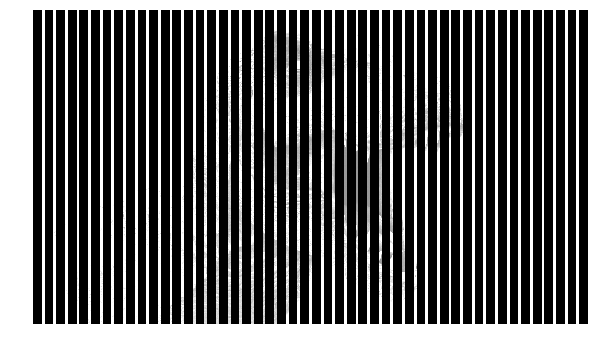

True

In [3]:
# Increase the pixel intensity by a value v
def addWeight(img, v):
    copy = img.astype(int)
    copy += v
    copy[ copy > 255 ] = 255
    return copy

# Draw vertical rectangle
def vertical_rectangle(img, p, width, color):
    img[:,p:p+width] = color

# Draw several vertical rectangles
def vertical_strips(img, width, spacing, color):
    copy = img.copy()
    h,w = copy.shape
    sw = 0
    while(sw < w):
        vertical_rectangle(copy, sw, width, color)
        sw += width + spacing
    return copy

# Apply weight and draw vertical rectangles
def efect(img, weight, width, spacing, color):
    weighted = addWeight(img, weight)
    return vertical_strips(weighted, width, spacing, color)

t_rex2 = efect(t_rex, 150, 15, 5, 0)

plt.figure(figsize=(10, 10))
plt.imshow(t_rex2, cmap='gray')
plt.axis('off')
plt.show()

cv2.imwrite('images/t_rex_stripes.jpg', t_rex2)

## 1.2 Write a program that smooths the above image to looks like the original image.

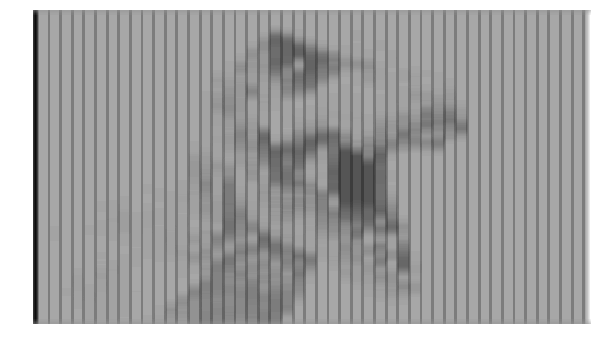

True

In [4]:
def blur(img, size):
    copy = img.astype(int)
    h,w = copy.shape
    
    surrounded = copy.mean() * np.ones((h + 2*(size//2), w + 2*(size//2)), dtype=int)
    surrounded[size//2:h + size//2, size//2:w + size//2] = copy
    
    for row in range(h):
        for col in range(w):
            copy[row,col] = np.sum(surrounded[row : row + size, col: col+size]) // (size*size)
    
    return copy
    
blured = blur(t_rex2, 19)

plt.figure(figsize=(10, 10))
plt.imshow(blured, cmap='gray')
plt.axis('off')
plt.show()

cv2.imwrite('images/t_rex_blur.jpg', blured)

## 2. Write a program to apply selective smoothness on the image.

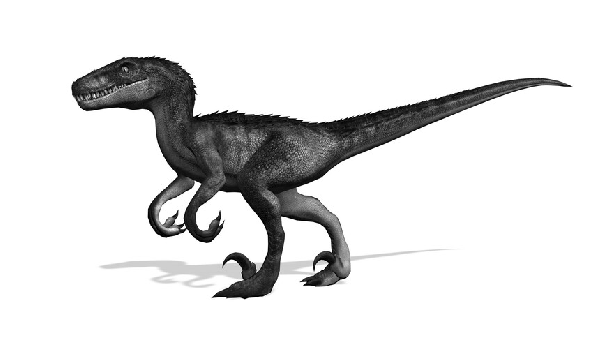

In [26]:
velociraptor = cv2.imread('images/velociraptor.jpg', 0)

plt.figure(figsize=(10, 10))
plt.imshow(velociraptor, cmap='gray')
plt.axis('off')
plt.show()

In [6]:
def magnitude_gradient(start, final):
    delta_i = np.zeros((final-start,final-start), dtype=float)
    for i in range(start, final + 1):
        for j in range(start, final + 1):
            delta_i[i + final - 1, j + final - 1] = sqrt( i**2 + j ** 2 )
        
    return delta_i

delta_i = magnitude_gradient(-1020, 1020)

In [53]:
def local_conv(img, kernel, cx, cy, norm=False, maxv=None, minv=None):
    kh,kw = kernel.shape
    size = kh // 2
    
    h,w = img.shape
    
    result = 0
    
    kernel_x = 0
    kernel_y = 0
    
    for i in range(cx - size, cx + size + 1):
        for j in range(cy - size, cy + size + 1):
            if i >= 0 and j >= 0 and i < h and j < w:
                result += abs(img[i,j] * kernel[kernel_x, kernel_y])
            kernel_y += 1
        kernel_y = 0
        kernel_x += 1
    
    if norm:
        result = int(255 * (result + maxv) / (maxv - minv))
        
    return result

def sobelx(img):
    kernel = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    copy = img.copy()
    h,w = img.shape
    
    for i in range(h):
        for j in range(w):
            copy[i,j] = local_conv(img, kernel, i, j, True, 1020, -1020)
            
    return copy

def sobely(img):
    kernel = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
    copy = img.copy()
    h,w = img.shape
    
    for i in range(h):
        for j in range(w):
            copy[i,j] = local_conv(img, kernel, i, j, True, 1020, -1020)
            
    return copy

def bitwise_or(img1, img2, norm=False):
    result = img1.astype(int) + img2.astype(int)    
    minv = img1.astype(int).min() + img2.astype(int).min()
    maxv = img1.astype(int).max() + img2.astype(int).max()
    
    if norm:
        result = 255 * (result + maxv) // (maxv - minv)
    
    return result

velociraptor_sobelx = sobelx(velociraptor)
velociraptor_sobely = sobely(velociraptor)
velociraptor_sobelxy = bitwise_or(velociraptor_sobelx, velociraptor_sobely)

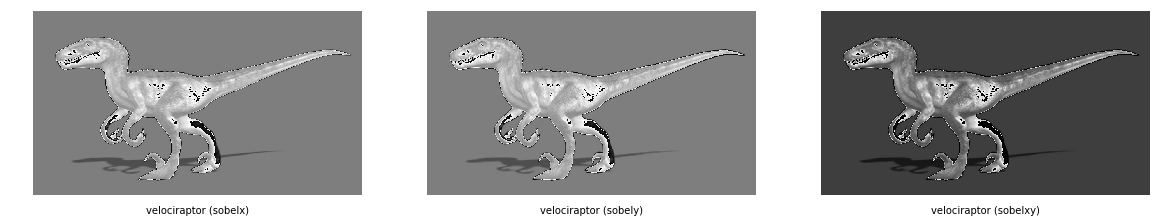

True

In [74]:
def bitwise_and(img1, img2, norm=False):
    result = img1.astype(int) * img2.astype(int)    
    minv = img1.astype(int).min() * img2.astype(int).min()
    maxv = img1.astype(int).max() * img2.astype(int).max()
    
    if norm:
        result = ((result + maxv) / (maxv - minv) - 1) * 255
    return result.astype(int)

velociraptor_sobelxy = bitwise_and(velociraptor_sobelx, velociraptor_sobely, True)

plt.figure(figsize=(20,10))
ax1 = plt.subplot(131)
ax1.imshow(velociraptor_sobelx, cmap='gray')
ax2 = plt.subplot(132)
ax2.imshow(velociraptor_sobely, cmap='gray')
ax3 = plt.subplot(133)
ax3.imshow(velociraptor_sobelxy, cmap='gray')

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

ax1.text(0.5,-0.1, "velociraptor (sobelx)", ha="center", transform=ax1.transAxes)
ax2.text(0.5,-0.1, "velociraptor (sobely)", ha="center", transform=ax2.transAxes)
ax3.text(0.5,-0.1, "velociraptor (sobelxy)", ha="center", transform=ax3.transAxes)

plt.show()
cv2.imwrite('images/velociraptor_sobelxy.jpg', velociraptor_sobelxy)

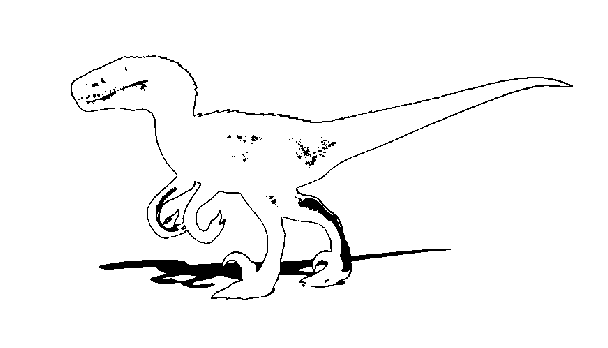

In [78]:
def threshold(img, limit, min_color, max_color):
    copy = img.copy()
    range_max = img > limit
    range_min = img <= limit

    copy[range_max] = max_color;
    copy[range_min] = min_color;
    return copy

binary = threshold(velociraptor_sobelxy, 50, 0, 255)
plt.figure(figsize=(10, 10))
plt.imshow(binary, cmap='gray')
plt.axis('off')
plt.show()

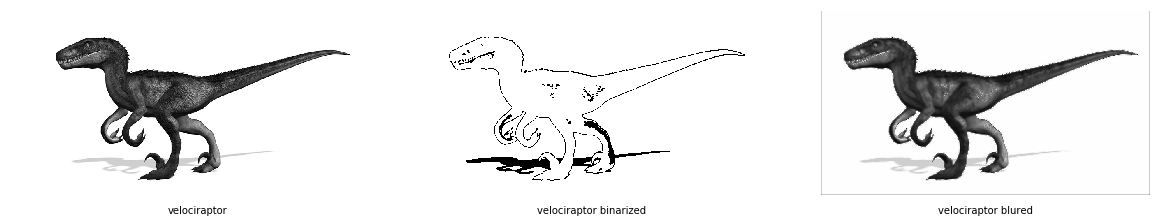

True

In [69]:
def selective_smooth(img, binary, blur_min, blur_max):
    kernel_min = (1 / (blur_min * blur_min)) * np.ones((blur_min,blur_min), dtype=float)
    kernel_max = (1 / (blur_max * blur_max)) * np.ones((blur_max,blur_max), dtype=float)
    
    copy = img.copy()
    h,w = copy.shape[0:2]
    
    for i in range(h):
        for j in range(w):
            if binary[i,j] == 0:
                if len(copy.shape) > 2:
                    for k in range(copy.shape[2]):
                        copy[i,j,k] = local_conv(img[:,:,k], kernel_min, i, j)
                else:
                    copy[i,j] = local_conv(img, kernel_min, i, j)
            else:
                if len(copy.shape) > 2:
                    for k in range(copy.shape[2]):
                        copy[i,j,k] = local_conv(img[:,:,k], kernel_max, i, j)
                else:
                    copy[i,j] = local_conv(img, kernel_max, i, j)
    return copy

velociraptor_blured = selective_smooth(velociraptor, binary, 1, 5)

plt.figure(figsize=(20,10))
ax1 = plt.subplot(131)
ax1.imshow(velociraptor, cmap='gray')
ax2 = plt.subplot(132)
ax2.imshow(binary, cmap='gray')
ax3 = plt.subplot(133)
ax3.imshow(velociraptor_blured, cmap='gray')

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

ax1.text(0.5,-0.1, "velociraptor", ha="center", transform=ax1.transAxes)
ax2.text(0.5,-0.1, "velociraptor binarized", ha="center", transform=ax2.transAxes)
ax3.text(0.5,-0.1, "velociraptor blured", ha="center", transform=ax3.transAxes)

plt.show()
cv2.imwrite('images/velociraptor_blured.jpg', velociraptor_blured)